# [GD-08] Seq2seq
"Going Deeper Node 8. Making translator using Seq2seq" / 2022. 04. 07 (Thu) 이형주

## Contents
---
- **1. Environment Setup**
- **2. Modeling**
- **3. Project Retrospective**

## Rubric 평가기준
---

|  평가문항  |  상세기준  |
|:---------|:---------|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.|구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
|2. Attentional Seq2seq 모델이 정상적으로 구동된다.|seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.|테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.

In [ ]:
# Colab Pro GPU 정보
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr  7 18:42:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Colab Pro Ram 정보
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## 1. Environment Setup

In [ ]:
import tensorflow as tf
import numpy as np
import time
import re
import os
import io
import random
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

In [ ]:
import tarfile
import urllib

# Source: https://colab.research.google.com/github/Shaam93/Building-a-classifer-with-Pytorch/blob/master/Uploading_Data_to_Google_Colab.ipynb#scrollTo=z55wuhC_Lm6E

## 다운받을 파일 경로
DEV_URL = "https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.dev.tar.gz?raw=true"
TEST_URL = "https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.test.tar.gz?raw=true"
TRAIN_URL = "https://github.com/jungyeul/korean-parallel-corpora/blob/master/korean-english-news-v1/korean-english-park.train.tar.gz?raw=true"

## 파일을 저장할 디렉토리 경로
DATA_PATH = os.path.join("datasets")

tar = tarfile.open(DEV_URL)
tar += tarfile.open(TEST_URL)
tar += tarfile.open(TRAIN_URL)
tar.extractall()
tar.close()

FileNotFoundError: ignored

경로 누르면 다운로드 잘만 되는데, 계속 경로 에러가 발생하여 구글 드라이브에 마운트하는 방법으로 해결한다.

github rawcontents로 시도하면 404 error가 발생한다.

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_content_korean_english_news = '/content/drive/My Drive/Colab Notebooks/korean-english-news-v1'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 파일 로드에 대한 정의

## 데이터 사이즈란 상단에 지정한 폴더 경로에서 파일을 열고, 데이터를 한줄씩 나눠(splitlines) 길이를 측정한다.
## 예시(example)란 처음부터 100번째 데이터까지, 그 안에 20개 단위로 끊어 한줄씩 보여준다. 그래서 각 파일별 5개씩 출력되는 원리다.

def load_file(file_name):
    with open(my_content_korean_english_news + '/{}'.format(file_name), "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")

    for sen in raw[0:100][::20]: 
        print(">>", sen)
    
    return raw

In [ ]:
# 한국어 데이터 로드 성공!

## korean_raw_data 변수는 load_file 함수에 있는 train, dev, test 파일에 대하여
## train.ko 파일을 첫 번째로 지정한다.
## 그 다음 train.ko + dev.ko가 된 상태(+=)를 지정한다.
## 그 다음 train.ko + dev.ko + test.ko가 된 상태(+=)로 지정한다.
## 그러면 한국어 데이터셋 3개가 합쳐지게 되므로, 그 'korean_raw_data'의 총 갯수를 print 한다.

korean_raw_data = load_file('korean-english-park.train.ko')
korean_raw_data += load_file('korean-english-park.dev.ko')
korean_raw_data += load_file('korean-english-park.test.ko')

print('한국어 데이터 사이즈는 총합 : ', len(korean_raw_data), '개 입니다. ^^')

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
Data Size: 1000
Example:
>> 세계 에서 가장 강력한 수퍼컴퓨터를 1년 동안이나 독점해 오던 정부의 연구학자들이 이 1억1천만 달러 짜리 경이로운 설비를 공개하며, 이것이 핵전쟁으로부터 세계를 구하는데 도움이 될지도 모른다고 말했다.
>> 무기 사찰관들의 복귀에 대하여 이라크 측의 한 관리가 "유익하고 효과적인" 논의였다고 말한 회합에서 유엔 무기 사찰단장이 이라크 대표단을 만났다.
>> 하드웨어를 구입하는 비용의 문제가 커다란 장애입니다.
>> 토의에 참가한 대부분의 사람들은 정부가 통신 내용을 도청할 수 있는 권리를 보유해야 할 필요성이 있는 합법적인 부분도 있다는 데에 동의를 한다.
>> 그는 눈에 띄지 않게 행동하는 것으로 알려져있다. 그는 영국 시사잡지 타임즈에서 “파티에 잘 참석하지 않는다”며 자신의 생활에 대한 날조된 이야기를 즐기고 있다.
Data Size: 2000
Example:
>> 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
>> 비록 그 위협(의 가능성)은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다.
>> 한국은 세계 에서 네번째로 원유를 많이 수입

In [ ]:
# 영어 데이터 로드 성공!

## english_raw_data 변수는 load_file 함수에 있는 train, dev, test 파일에 대하여
## train.en 파일을 첫 번째로 지정한다.
## 그 다음 train.en + dev.en가 된 상태(+=)를 지정한다.
## 그 다음 train.en + dev.en + test.en가 된 상태(+=)로 지정한다.
## 그러면 한국어 데이터셋 3개가 합쳐지게 되므로, 그 'english_raw_data'의 총 갯수를 print 한다.

english_raw_data = load_file('korean-english-park.train.en')
english_raw_data += load_file('korean-english-park.dev.en')
english_raw_data += load_file('korean-english-park.test.en')

print('영어 데이터 사이즈는 총합 : ', len(english_raw_data), '개 입니다. ^^')

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
Data Size: 1000
Example:
>> After keeping the world's most powerful supercomputer to themselves for a year, government researchers showed off the $110 million wonder and said it might help save the world from nuclear war.
>> The head of the U.N. weapons inspection

In [ ]:
# 데이터 전처리 과정

## data_zip이라는 변수는 korean_raw_data, english_raw_data 변수 내 데이터를 묶는다.
## removed_data_duplicates 변수는 data_zip 변수에 있는 '묶인 데이터' 내 중복을 set 데이터 함수를 활용하여 제거한다.
## 중복 제거된 removed_data_duplicates 변수 내 데이터 갯수를 본다.

data_zip = zip(korean_raw_data, english_raw_data)
removed_data_duplicates = set(data_zip)
len(removed_data_duplicates)

81959

In [ ]:
## processed_korean_data, processed_english_data 변수는 앞서 중복 제거한 removed_data_duplicates 변수에 묶여있음을 지정한다.
## zip(*iterable) 형태는, 동일한 갯수로 이뤄진 자료형을 묶어주는 역할을 한다. ==> zip(*removed_data_duplicates)
## 처리된 korean data, english data 사이즈가 81,959개로 동일하다.

processed_korean_data, processed_english_data = zip(*removed_data_duplicates)
print('전처리된 한국어 데이터 결과는: ',len(processed_korean_data),'개 입니다.')
print('전처리된 영어 데이터 결과는: ',len(processed_english_data),'개 입니다.')
print('전처리된 한국어 예시문장 한 번 보시죠: "',processed_korean_data[50],'" 잘 나오죠?')
print('전처리된 영어 예시문장 한 번 보시죠: "',processed_english_data[50],'" 잘 나오죠?')

전처리된 한국어 데이터 결과는:  81959 개 입니다.
전처리된 영어 데이터 결과는:  81959 개 입니다.
전처리된 한국어 예시문장 한 번 보시죠: " 토코리야는 칠레 수도 산티아고 북쪽으로 1245km 떨어진 지역이다. " 잘 나오죠?
전처리된 영어 예시문장 한 번 보시죠: " Tocopilla is located about 780 miles (1,245 kilometers) north of the capital, Santiago. " 잘 나오죠?


In [ ]:
## 전처리 문장을 함수로 정의한다. 여기에서는 불필요한 특수문자를 정제한다.
## sentence 변수는 문장을 소문자로 변환하며 문자열 좌우에 위치한 공백도 동시에 제거한다.

## re(regular expression, 정규표현식).sub을 이용하여 문자열을 바꿔준다.
### 1) [정규 표현식, 대상 문자열, 치환 문자] 형태로 구성된다.
### 2) \1, 공백에 대하여 정규표현식에 따라 공백이 제거된 sentence로 바뀌게 된다.

def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!가-힣ㄱ-ㅎㅏ-ㅣ]+", " ", sentence)

    sentence = sentence.strip()

### 3) 정규표현식에 따라 정제된 특수문자와 공백들은 <start> <end>를 문장 앞뒤에 붙인다.
### 4) s_token은 정제된 문장 앞에 <start>를 붙인다.
### 5) e_token은 정제된 문장 뒤에 <end>를 붙인다.

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
        
### 6) 기본값은 s_token, e_token 모두 False 이므로 (def preprocess_sentence) 둘 다 해당이 안되면 sentence를 return 한다.
    return sentence

In [ ]:
encoder_co = []
decoder_co = []

## encoder에 들어갈 말뭉치와, decoder_co에 들어갈 말뭉치에 대하여
## count 값 0을 시작점으로 하여 kor, eng 변수는 processed_korean, english data의 집합으로 되어 있다.
## temp_eng 변수는 전처리된 영어문장을 가리키며 시작과 끝에 각각 <start> <end>를 붙여주도록 True 처리된다.

count = 0
for kor, eng in zip(processed_korean_data, processed_english_data):
    temp_kor = preprocess_sentence(kor)
    temp_eng = preprocess_sentence(eng, s_token=True, e_token=True)

## 모델 학습속도를 높이기 위하여, 토큰(전처리된 데이터) 길이가 40 이하인 모든 데이터에
## encoder.co 변수에 temp_kor(전처리된 한국어)를 추가하고
## decoder.co 변수에 temp_eng(전처리된 영어)를 추가한다.

    if len(temp_kor) <= 40:
        encoder_co.append(temp_kor)
        decoder_co.append(temp_eng)

## 인코더에 있는 한국어 말뭉치가 데이터 사이즈가 되고
## 디코더에 있는 영어 말뭉치가 데이터 사이즈가 되며
## 한국어와 영어 문장을 예시로 보여준다. 영어는 앞뒤로 <start> <end>가 각각 잘 붙는다.

print('한국어 데이터 사이즈는:', len(encoder_co))
print('영어 데이터 사이즈는:', len(decoder_co))
print("200번째 한국어 문장 예시:", encoder_co[200])   
print("200번째 영어 문장 예시:", decoder_co[200])
print("100번째 한국어 문장 예시:", encoder_co[100])   
print("100번째 영어 문장 예시:", decoder_co[100])

## 전처리가 아주 잘 되었다.
## 전처리를 해보니 단어 사이즈가 너무너무 적다. training, test로 나누는게 의미가 있을까 싶다.

한국어 데이터 사이즈는: 17055
영어 데이터 사이즈는: 17055
200번째 한국어 문장 예시: 수성에 카이퍼의 동쪽 지대는 이제까지 사진에 찍힌 적이 없었다 .
200번째 영어 문장 예시: <start> most of the terrain east of kuiper had never before been photographed . <end>
100번째 한국어 문장 예시: 이렇게 하는 대신 베이킹소다를 준비한다 .
100번째 영어 문장 예시: <start> instead reach for your baking soda . <end>


In [ ]:
# Colab에 Mecab name 'Tagger' is not defined 오류 없이 설치하는 방법
# Source: https://sosomemo.tistory.com/31

!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-le

In [ ]:
# 단어 자체가 너무 적어서 30,000으로 사이즈를 임의로 잡는다.
vocab_size = 30000

# Tokenize 함수를 정의하여 데이터를 텐서의 형태로 변환한다.
## 1) 한국어 토큰화는 Konlpy의 Mecab를 사용하고 영어와 같이 keras tokenizer를 쓴다.
## 2) 패딩 처리까지 완료한다.

def tokenize(corpus, kor=False, eng=True):
    if kor:
        mecab = Mecab()
        morph = [" ".join(mecab.morphs(sen)) for sen in corpus]
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=vocab_size)
        tokenizer.fit_on_texts(morph)
        tensor = tokenizer.texts_to_sequences(morph)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
        
    if eng:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=vocab_size)
        tokenizer.fit_on_texts(corpus)
        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [ ]:
from konlpy.tag import Mecab

# Mecab을 사용하여 한국어 토큰화를 진행한다.
## train, test 데이터를 8:2 비율로 하여 단어사이즈를 나눈다. 

encoder_tensor, encoder_tokenizer = tokenize(encoder_co, kor=True)
decoder_tensor, decoder_tokenizer = tokenize(decoder_co, eng=True)

encoder_train, encoder_val, decoder_train, decoder_val = \
train_test_split(encoder_tensor, decoder_tensor, test_size=0.2)

print('80%로 지정된 한국어 단어사이즈는 :',len(encoder_tokenizer.index_word),' 입니다.')
print('20%로 지정된 영어 단어사이즈는 :',len(decoder_tokenizer.index_word),' 입니다.')

80%로 지정된 한국어 단어사이즈는 : 41796  입니다.
20%로 지정된 영어 단어사이즈는 : 17325  입니다.


## 2. Modeling

In [ ]:
# Attention 모델을 사용하여 모델링을 진행한다.

class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [ ]:
# Encoder 모델링

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [ ]:
# Decoder 모델링

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [ ]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(encoder_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(decoder_tokenizer.index_word) + 1

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# 샘플 결과확인
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 128)
Decoder Output: (64, 17326)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


In [ ]:
# Model Training
## Encoder-Decoder 구조로 설계하였으므로, Loss(손실함수) 커스텀이 필요하여 fit() 함수는 쓰지 않는다.

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)

## mask 변수는 패딩 처리된 토큰을 찾아서 손실로 처리하지 않게끔 한다.
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [ ]:
@tf.function
# tf.function 데코레이터는 Tensorflow 연산을 GPU에서 진행하게끔 만든다.
# train_step 함수는 학습 후에 Loss 결과를 반환한다.

def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

# tf.GradientTape()는 학습 과정에서의 모든 연산을 기록하여 최종 단계의 미분값을 구한다.
    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [23]:
# Model Training

import random
from tqdm import tqdm

EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, encoder_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(encoder_train[idx:idx+BATCH_SIZE],
                                decoder_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                decoder_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    test_loss = 0

## 프로젝트 기술요구 조건에 따라 eval_step 코드영역 제거

    idx_list = list(range(0, encoder_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    t.set_description_str('Test Epoch %2d' % (epoch + 1))

## Training Loss는 AS-IS 1.5738 -> TO-BE 0.80xx으로 유의미하게 감소하였다.

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Test Epoch 23:   0%|          | 0/54 [00:00<?, ?it/s]

Test Epoch 24:   0%|          | 0/54 [00:00<?, ?it/s]

Test Epoch 25:   0%|          | 0/54 [00:00<?, ?it/s]

Test Epoch 26:   0%|          | 0/54 [00:00<?, ?it/s]

Test Epoch 27:   0%|          | 0/54 [00:00<?, ?it/s]

Test Epoch 28:   0%|          | 0/54 [00:00<?, ?it/s]

Test Epoch 29:   0%|          | 0/54 [00:00<?, ?it/s]

Test Epoch 30:   0%|          | 0/54 [00:00<?, ?it/s]

In [24]:
# Model Evaluation

def evaluate(sentence, encoder, decoder):
    attention = np.zeros((decoder_train.shape[-1], encoder_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = encoder_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=encoder_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([decoder_tokenizer.word_index['<start>']], 0)

    for t in range(decoder_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += decoder_tokenizer.index_word[predicted_id] + ' '

        if decoder_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

In [25]:
# 한글폰트 설치

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 96 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 4 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existen

In [26]:
# 한글폰트 셋팅

%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

plt.rc('font', family='NanumGothic')

In [27]:
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
print(sys_font)

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

sys_font number: 49
['/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Oblique.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf', '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-Oblique.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans-BoldOblique.ttf', '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSerifCondensed.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans-Oblique.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-Bold.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf', '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf', '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSansMono.tt

In [28]:
nanum_font

['/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf']

In [29]:
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 설치된 나눔글꼴중 원하는 폰트의 전체 경로를 가져온다.
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

NanumGothic


In [30]:
!pip install matplotlib==3.4.3

Input: 오바마는 대통령이다 .
Predicted translation: obama s first time for the world s first time for the world s first time for the world s first time for the world s first time for the world s first time for the world s first time for the world s first time for the world s first time for the world s first time for the world s first time for the world 


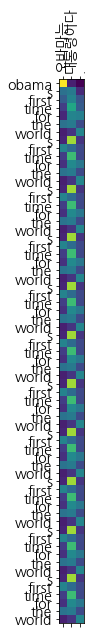

In [31]:
# 예문 1
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: the first time . <end> 


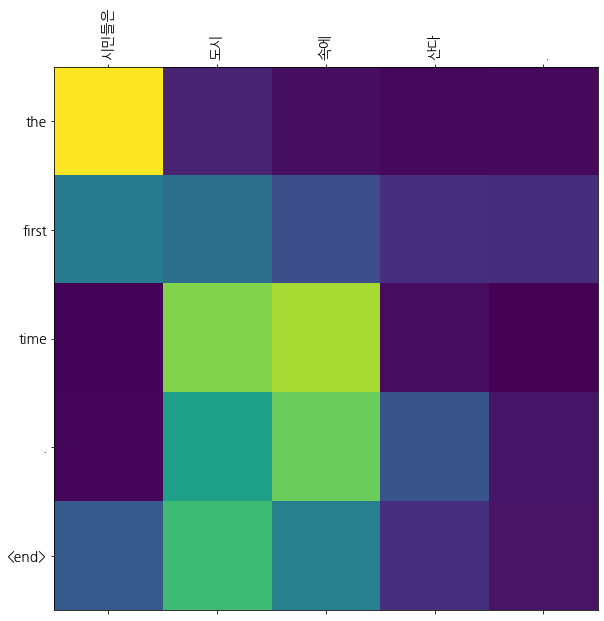

In [32]:
# 예문 2
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: http article . com . <end> 


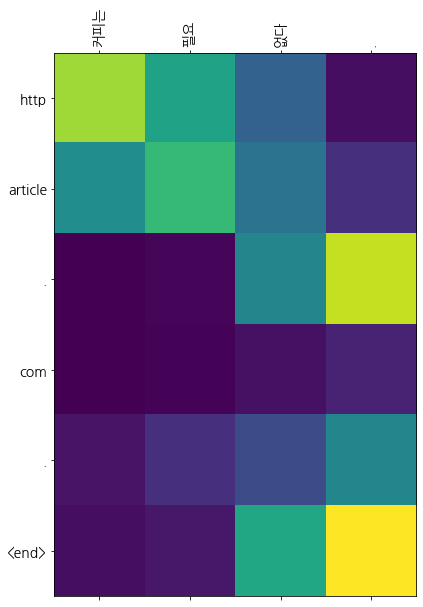

In [33]:
# 예문 3
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: the u . s . . <end> 


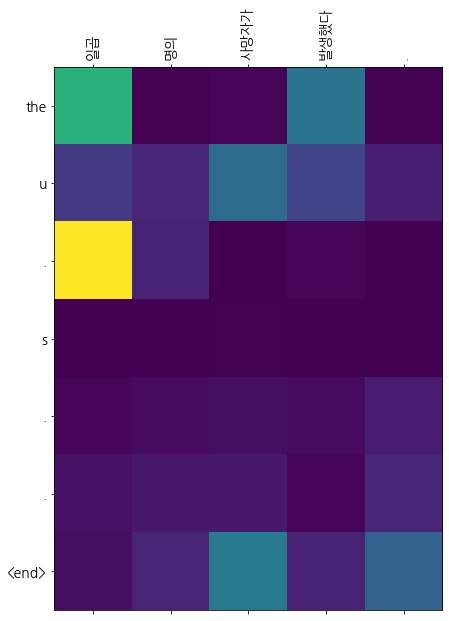

In [34]:
# 예문 4
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

## 3. Project Retrospective

+ EPOCH 수행 중에 Loss가 다시 증가한 것으로 보아, 단어수도 적은데 훈련을 많이 시키니 과적합이 발생한 것으로 보인다. 물론, 번역기 수행에 난이도가 있고 시각화를 했을 때 비교적 연관성은 잘 찾아냈지만 깔끔하게 번역이 수행되진 않은 것 같다.
+ 모델을 돌리면서 섬뜩한 에러가 10번 이상 등장하였다. 나름 좋은 성능을 가지고 있다고 생각했는데, 크롬 브라우저도 8GB 램 앞에서는 많이 힘들어하는 것 같다. 그래도 Colab은 자체적으로 복구하여 모델 학습을 그대로 이어가는 기능이 있어 이 부분은 만족스럽다.

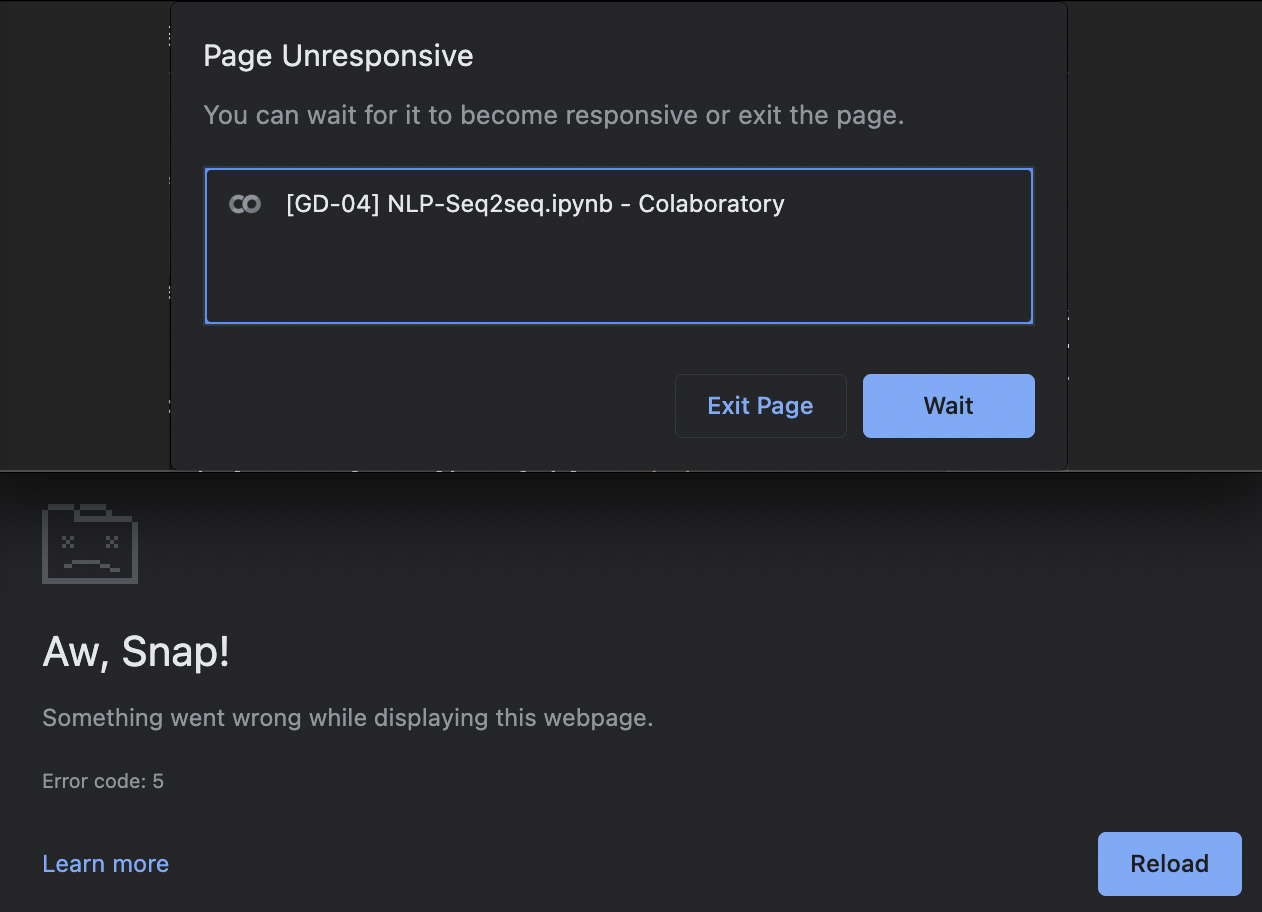

+ Modeling 전후 과정은 디테일하게 설명할 수 있을 정도로 편안해진 것 같다. 모델링의 경우에는 모델 특성을 생각하면서 공부해야 하기 때문에, 조금만 더 공을 들이면 더 만족스러운 성취감을 얻을 수 있지 않을까 생각한다.